### Imports

In [1]:
import boto3
import dask
import dilib
import os
import pathlib
import pytz
from collections import defaultdict
from datetime import datetime, timedelta
from typing import Any

import pandas as pd
import numpy as np
import rich

from epoch_data import athena
from epoch_data import calendarlib
from epoch_data import hdstorelib
from epoch_infra import commonlib
from epoch_infra import clusterlib
from epoch_infra import joblib
from epoch_markets import symlib
from epoch_markets.mdcatalog.options import data_config, instr_helper, job, job_config
from epoch_markets.symlib import options

from octopus import refdata_options
from octopus import datelib
from octopus import archives

### Helpers and Functions

In [2]:
def get_secmaster(path_prefix: str="/fsxcache/output") -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol="file",
        host=None,
        name_resolver=None,
        network_latency=None,
        path_prefix=path_prefix
    )

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,        
    )

    return secmaster

secmaster = get_secmaster()


def get_mapping_from_gsym(gsym: str) -> symlib.InstrumentMapping:
    return symlib.InstrumentKey.get_instrument_mapping(gsym)


def get_futures(
    gsym: str,
    trade_date: datetime.date,
) -> list[symlib.Instrument]:
    res = set()
    for offset in range(1, 3):
        key = symlib.InstrumentKey(gsym, trade_date, offset)
        res.add(secmaster.get_instrument(key))
    return list(res)


def get_options(
    gsym: str,
    start_date: datetime.date,
    end_date: datetime.date,
    is_complex: bool,
) -> list[symlib.Instrument]:
    res = []
    for trade_date in calendar.get_date_range(
        start_date, end_date, isoweekdays={1, 2, 3, 4, 5}
    ):
        res.extend(instr_helper.get_options(gsym, trade_date, trade_date, 0, is_complex=is_complex, secmaster=secmaster))
    return list(set(res))


def get_exchange_symbols(
    gsym: str,
    trade_date: datetime.date,
    is_complex: bool,
) -> list[str]:
    ids = instr_helper.get_exchange_symbols_and_sec_ids(trade_date, trade_date, calendar, gsym, is_complex=is_complex, secmaster=secmaster)
    return [i.exchange_symbol for i in ids]


# read a book parquet file for some symbol
# e.g. data = client.gather(client.compute(dask.delayed(get_book_data)("03Tzyk", calendar.get_date(20230921, forward=True), version)))
def get_book_data(exchange: str, gsym: str, symbol: str, trade_date: calendarlib.TradeDate, version: str):
    # /{fsx_location}/books/cboe/2023/01/03/v5/{symbol}/book.parquet
    args = dict(exchange=exchange, year=trade_date.year, month=trade_date.month_padded, 
                day=trade_date.day_padded, version=version, symbol=symbol, gsym=gsym)
    if exchange == "cme":
        book_location = "/fsxcache/output/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "cboe":
        book_location = "/fsxcache/old_output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "nymx":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    path = book_location.format(**args)
    print (path)
    files = ["book", "trades"]
    ret = {}
    for f in files:
        ret[f] = pd.read_parquet(f"{path}/{f}.parquet")
    return ret

def get_outright_1m_price_data_cache_hashes(trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    data_context = athena.DataContext(read_namespaces=["prod"], write_namespace="prod")
    container = data_config.get_options_container(data_context=data_context)
    core_market_dataset = container.config.core_market_dataset
    res = {}
    for key in keys:
        if exchange == "cme":
            res[key.exchange_security_id] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        else:
            res[key.exchange_symbol] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        return res

def validate_cached_downsampled_files(gsym: str, trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    res_list = []
    cache_hashes = get_outright_1m_price_data_cache_hashes(trade_date, keys)
    for exchange_symbol, cache_hash in cache_hashes.items():
        path = f"/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/{cache_hash}/{exchange_symbol}/{trade_date}.pickle"
        res = dict(symbol=exchange_symbol, date=trade_date, file_location=path)
        res[f"ds_file_exists"] = os.path.exists(path)
        res_list.append(res)
    return res_list

### Loading CH Refdata

In [3]:
with refdata_options.get_opt_refdata_dao(refdata_options.OptRefdataDao.TABLE_NAME_V2) as dao:
    ch_refdata = dao.get_all_refdata()

### Configuration

In [4]:
data_context = athena.DataContext(read_namespaces=["test", "prod"], write_namespace="test")
container = data_config.get_options_container(data_context=data_context)
core_market_dataset = container.config.core_market_dataset
source_market_dataset = container.config.source_market_dataset

In [5]:
# the cboe stream and book jobs produce files based on a given day's 5 day range symbols (v5)
# cme streams (v2) do as well but the books (v2.1) are based on a given day's 1 day range symbols
gsym =  "OES" # "OSPXW" # "OES"
base_asset = "OESW" # "OSPXW" # "OESW"
version = "v2.2" # "v5" # "v2.2"
is_complex = False
pcap_ch_table = 'historical.oes_1min_pcap_v1' # 'historical.spxw_1min_v1' #'historical.oes_1min_pcap_v1'
exchange = symlib.Exchanges.CME.name.lower()# symlib.Exchanges.CBOE.name.lower() #symlib.Exchanges.CME.name.lower()
calendar = container.config.ref_data_config.cme_calendar if exchange == "cme" else container.config.ref_data_config.cboe_calendar
trade_date = calendar.get_date(20230824, forward=True)

In [6]:
checks = {
    'options_count': False,
    'timestamp_boundaries': False,
    'options_missing_pcap': 0,
    'options_missing_trth': 0,
    'options': {}
}

### Getting Option Chain from secmaster

In [7]:
option_chain = get_options(gsym, trade_date, trade_date, False)

#### Check - Options Count

In [8]:
def check_options_count(d: datetime.date, base_asset:str, option_chain: list[symlib.Instrument], ch_refdata: pd.DataFrame):
    expiry_date = np.datetime64(d)
    oesw_refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
    if len(oesw_refdata_options.index) == len(option_chain):
        print (f'CHECK - Options Count - SUCCESS ({len(option_chain)})')
        checks['options_count'] = True
    else:
        print ('CHECK - Options Count - ERROR')
        print(f'Refinitiv: {len(oesw_refdata_options.index)} - PCAP: {len(option_chain)})')

In [9]:
check_options_count(trade_date, base_asset, option_chain, ch_refdata)
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]

CHECK - Options Count - SUCCESS (548)


### Getting Market Data

In [10]:
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')      

In [11]:
rich.print(times_begin)
rich.print(times_end)

2023-08-24 00:00:00+00:00

2023-08-24 20:00:00+00:00

In [12]:
db_archives = archives.ClickArchive(pcap_ch_table)
pcap_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )

In [13]:
db_archives = archives.ClickArchive('historical.trthopt_1min_v7')
trth_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )

In [14]:
pcap_df.set_index(['timestamp'], drop=False, inplace=True)
pcap_df.sort_index(inplace=True)
trth_df.set_index(['timestamp'], drop=False, inplace=True)
trth_df.sort_index(inplace=True)

### Checking Market Data Timestamp boundaries

In [15]:
trth_min_timestamp = trth_df.timestamp.min()
trth_max_timestamp = trth_df.timestamp.max()
pcap_min_timestamp = pcap_df.timestamp.min()
pcap_max_timestamp = pcap_df.timestamp.max()
if trth_min_timestamp == pcap_min_timestamp and trth_max_timestamp == pcap_max_timestamp:
    print (f'CHECK - Timestamp boundaries - SUCCESS {trth_min_timestamp} -> {trth_max_timestamp}')
    checks['timestamp_boundaries'] = True
else:
    print ('CHECK - Timestamp boundaries - ERROR')
    print (f'Min Timestamp: trth:{trth_min_timestamp} pcap:{pcap_min_timestamp} equal:{trth_min_timestamp == pcap_min_timestamp}')
    print (f'Max Timestamp: trth:{trth_max_timestamp} pcap:{pcap_max_timestamp} equal:{trth_max_timestamp == pcap_max_timestamp}')

CHECK - Timestamp boundaries - ERROR
Min Timestamp: trth:2023-08-24 00:00:00+00:00 pcap:2023-08-24 05:00:00+00:00 equal:False
Max Timestamp: trth:2023-08-24 19:59:00+00:00 pcap:2023-08-24 19:59:00+00:00 equal:True


In [16]:
def check_option_timestamp(symbol):
    sym_trth = trth_df[(trth_df.symbol == symbol)]
    sym_pcap = pcap_df[(pcap_df.symbol == symbol)]

    trth_min_timestamp = sym_trth.timestamp.min()
    trth_max_timestamp = sym_trth.timestamp.max()
    pcap_min_timestamp = sym_pcap.timestamp.min()
    pcap_max_timestamp = sym_pcap.timestamp.max()
    if trth_min_timestamp == pcap_min_timestamp and trth_max_timestamp == pcap_max_timestamp:
        print (f'{symbol} - CHECK - Timestamp boundaries - SUCCESS {trth_min_timestamp} -> {trth_max_timestamp}')
    else:
        print ('CHECK - Timestamp boundaries - ERROR')
        print (f'{symbol} Min Timestamp: trth:{trth_min_timestamp} pcap:{pcap_min_timestamp} equal:{trth_min_timestamp == pcap_min_timestamp}')
        print (f'{symbol} Max Timestamp: trth:{trth_max_timestamp} pcap:{pcap_max_timestamp} equal:{trth_max_timestamp == pcap_max_timestamp}')


#for symbol in refdata_options.symbol:
#    check_option_timestamp(symbol)

### Checking an option

In [17]:
def remove_missing_timestamps(sym_trth, sym_pcap):
    # Remove missing timestamps when refinitiv does not have them
    # This happens when the prices is the same between minutes
    # I am unsure if it is Refinitiv and Post Processing in MFT
    missings = sym_pcap.index.difference(sym_trth.index)
    return sym_pcap.drop(missings)

def remove_timestamps_with_nans(sym_trth, sym_pcap):
    nan_index = sym_pcap[(sym_pcap.bid.isna()) | (sym_pcap.ask.isna())].index
    sym_trth_temp = sym_trth.drop(nan_index)
    sym_pcap_temp = sym_pcap.drop(nan_index)
    nan_index = sym_trth_temp[(sym_trth_temp.bid.isna()) | (sym_trth_temp.ask.isna())].index
    sym_trth_final = sym_trth_temp.drop(nan_index)
    sym_pcap_final = sym_pcap_temp.drop(nan_index)
    return sym_trth_final, sym_pcap_final

def check_option(trade_date, symbol: str, trth_df, pcap_df):
    
    sym_trth = trth_df[(trth_df.symbol == symbol)]
    sym_pcap = pcap_df[(pcap_df.symbol == symbol)]
    
    print (f'TRTH len: {len(sym_trth)}')
    print (f'PCAP len: {len(sym_pcap)}')

    # We know that we could have missing timestamps in both sides and we just want to check the
    # ones in common
    sym_pcap_filtered = remove_missing_timestamps(sym_trth, sym_pcap)
    sym_trth_filtered = remove_missing_timestamps(sym_pcap_filtered, sym_trth)


    print (f'TRTH missing len: {len(sym_trth_filtered)}')
    print (f'PCAP missing len: {len(sym_pcap_filtered)}')
    
    # We remove the nans as the logic in Refinitiv is dodgy
    sym_trth_filtered, sym_pcap_filtered = remove_timestamps_with_nans(sym_trth_filtered, sym_pcap_filtered)

    print (f'TRTH filtered len: {len(sym_trth_filtered)}')
    print (f'PCAP filtered len: {len(sym_pcap_filtered)}')

    # Log how many timestamps we have a difference
    results = pd.DataFrame()
    results['bid'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.bid) | np.isclose(sym_trth_filtered.bid, sym_pcap_filtered.bid)
    results['ask'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.ask) | np.isclose(sym_trth_filtered.ask, sym_pcap_filtered.ask)
    issues = results[~results.bid| ~results.ask]
    rich.print(issues)

In [18]:
for symbol in refdata_options.symbol:
    check_option(trade_date, symbol, trth_df, pcap_df)

TRTH len: 1124
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 367
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 367
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 372
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 377
PCAP len: 900
TRTH missing len: 355
PCAP missing len: 355
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 377
PCAP len: 900
TRTH missing len: 355
PCAP missing len: 355
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 375
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 375
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 351
PCAP missing len: 351
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 380
PCAP len: 900
TRTH missing len: 353
PCAP missing len: 353
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 06:01:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1119
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00  False   True
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:44:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1130
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 806
PCAP filtered len: 806


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 335
PCAP filtered len: 335


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 335
PCAP filtered len: 335


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 339
PCAP filtered len: 339


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 353
PCAP filtered len: 353


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 375
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 814
PCAP filtered len: 814


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 375
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 372
PCAP filtered len: 372


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 375
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 375
PCAP filtered len: 375


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 378
PCAP filtered len: 378


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 379
PCAP filtered len: 379


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 374
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1125
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 828
PCAP filtered len: 828


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 383
PCAP filtered len: 383


bid    ask
timestamp                              
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 383
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 385
PCAP filtered len: 385


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 381
PCAP len: 900
TRTH missing len: 346
PCAP missing len: 346
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 388
PCAP filtered len: 388


bid    ask
timestamp                              
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True

TRTH len: 382
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 459
PCAP len: 471
TRTH missing len: 459
PCAP missing len: 459
TRTH filtered len: 435
PCAP filtered len: 435


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 385
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1128
PCAP len: 900
TRTH missing len: 878
PCAP missing len: 878
TRTH filtered len: 843
PCAP filtered len: 843


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 382
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 449
PCAP filtered len: 449


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1129
PCAP len: 900
TRTH missing len: 878
PCAP missing len: 878
TRTH filtered len: 844
PCAP filtered len: 844


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 380
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 380
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True

TRTH len: 380
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 380
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1130
PCAP len: 900
TRTH missing len: 878
PCAP missing len: 878
TRTH filtered len: 843
PCAP filtered len: 843


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 382
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 384
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False

TRTH len: 390
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True

TRTH len: 391
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 380
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1130
PCAP len: 900
TRTH missing len: 878
PCAP missing len: 878
TRTH filtered len: 843
PCAP filtered len: 843


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 379
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 378
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 364
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 365
PCAP len: 900
TRTH missing len: 349
PCAP missing len: 349
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1131
PCAP len: 900
TRTH missing len: 879
PCAP missing len: 879
TRTH filtered len: 843
PCAP filtered len: 843


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 365
PCAP len: 900
TRTH missing len: 350
PCAP missing len: 350
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 473
PCAP len: 875
TRTH missing len: 473
PCAP missing len: 473
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 364
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 473
PCAP len: 875
TRTH missing len: 473
PCAP missing len: 473
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 362
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 473
PCAP len: 875
TRTH missing len: 473
PCAP missing len: 473
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:57:00+00:00  False   True

TRTH len: 363
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 473
PCAP len: 875
TRTH missing len: 473
PCAP missing len: 473
TRTH filtered len: 450
PCAP filtered len: 450


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:57:00+00:00  False   True

TRTH len: 367
PCAP len: 900
TRTH missing len: 351
PCAP missing len: 351
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1133
PCAP len: 900
TRTH missing len: 880
PCAP missing len: 880
TRTH filtered len: 845
PCAP filtered len: 845


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 363
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 473
PCAP len: 875
TRTH missing len: 473
PCAP missing len: 473
TRTH filtered len: 453
PCAP filtered len: 453


bid    ask
timestamp                              
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 362
PCAP len: 900
TRTH missing len: 347
PCAP missing len: 347
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 474
PCAP len: 875
TRTH missing len: 474
PCAP missing len: 474
TRTH filtered len: 454
PCAP filtered len: 454


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 370
PCAP len: 900
TRTH missing len: 355
PCAP missing len: 355
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 474
PCAP len: 875
TRTH missing len: 474
PCAP missing len: 474
TRTH filtered len: 455
PCAP filtered len: 455


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 369
PCAP len: 900
TRTH missing len: 352
PCAP missing len: 352
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 475
PCAP len: 876
TRTH missing len: 475
PCAP missing len: 475
TRTH filtered len: 455
PCAP filtered len: 455


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 370
PCAP len: 900
TRTH missing len: 354
PCAP missing len: 354
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1134
PCAP len: 900
TRTH missing len: 881
PCAP missing len: 881
TRTH filtered len: 847
PCAP filtered len: 847


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:05:00+00:00  False   True
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 372
PCAP len: 900
TRTH missing len: 356
PCAP missing len: 356
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 476
PCAP len: 876
TRTH missing len: 476
PCAP missing len: 476
TRTH filtered len: 456
PCAP filtered len: 456


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 373
PCAP len: 900
TRTH missing len: 356
PCAP missing len: 356
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 478
PCAP len: 876
TRTH missing len: 478
PCAP missing len: 478
TRTH filtered len: 456
PCAP filtered len: 456


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 375
PCAP len: 900
TRTH missing len: 356
PCAP missing len: 356
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 480
PCAP len: 876
TRTH missing len: 480
PCAP missing len: 480
TRTH filtered len: 458
PCAP filtered len: 458


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 376
PCAP len: 900
TRTH missing len: 358
PCAP missing len: 358
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 481
PCAP len: 876
TRTH missing len: 481
PCAP missing len: 481
TRTH filtered len: 459
PCAP filtered len: 459


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 372
PCAP len: 900
TRTH missing len: 355
PCAP missing len: 355
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1135
PCAP len: 900
TRTH missing len: 880
PCAP missing len: 880
TRTH filtered len: 849
PCAP filtered len: 849


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 379
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 488
PCAP len: 876
TRTH missing len: 488
PCAP missing len: 488
TRTH filtered len: 463
PCAP filtered len: 463


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 396
PCAP len: 900
TRTH missing len: 383
PCAP missing len: 383
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 499
PCAP len: 876
TRTH missing len: 498
PCAP missing len: 498
TRTH filtered len: 466
PCAP filtered len: 466


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 423
PCAP len: 900
TRTH missing len: 407
PCAP missing len: 407
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 508
PCAP len: 876
TRTH missing len: 505
PCAP missing len: 505
TRTH filtered len: 470
PCAP filtered len: 470


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 439
PCAP len: 900
TRTH missing len: 422
PCAP missing len: 422
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 519
PCAP len: 876
TRTH missing len: 511
PCAP missing len: 511
TRTH filtered len: 474
PCAP filtered len: 474


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 445
PCAP len: 900
TRTH missing len: 422
PCAP missing len: 422
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1150
PCAP len: 900
TRTH missing len: 882
PCAP missing len: 882
TRTH filtered len: 853
PCAP filtered len: 853


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 447
PCAP len: 900
TRTH missing len: 427
PCAP missing len: 427
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 702
PCAP len: 899
TRTH missing len: 526
PCAP missing len: 526
TRTH filtered len: 484
PCAP filtered len: 484


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 469
PCAP len: 900
TRTH missing len: 442
PCAP missing len: 442
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 733
PCAP len: 899
TRTH missing len: 550
PCAP missing len: 550
TRTH filtered len: 492
PCAP filtered len: 492


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 457
PCAP len: 900
TRTH missing len: 428
PCAP missing len: 428
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 758
PCAP len: 899
TRTH missing len: 574
PCAP missing len: 574
TRTH filtered len: 502
PCAP filtered len: 502


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 509
PCAP len: 900
TRTH missing len: 479
PCAP missing len: 479
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 786
PCAP len: 900
TRTH missing len: 596
PCAP missing len: 596
TRTH filtered len: 519
PCAP filtered len: 519


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:50:00+00:00  False  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 481
PCAP len: 900
TRTH missing len: 444
PCAP missing len: 444
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1160
PCAP len: 900
TRTH missing len: 884
PCAP missing len: 884
TRTH filtered len: 858
PCAP filtered len: 858


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 08:50:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:34:00+00:00  False   True
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 455
PCAP len: 900
TRTH missing len: 452
PCAP missing len: 452
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 866
PCAP len: 900
TRTH missing len: 657
PCAP missing len: 657
TRTH filtered len: 568
PCAP filtered len: 568


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:40:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 530
PCAP len: 900
TRTH missing len: 500
PCAP missing len: 500
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 929
PCAP len: 900
TRTH missing len: 707
PCAP missing len: 707
TRTH filtered len: 602
PCAP filtered len: 602


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 493
PCAP len: 900
TRTH missing len: 453
PCAP missing len: 453
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1150
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 861
PCAP filtered len: 861


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 481
PCAP len: 900
TRTH missing len: 449
PCAP missing len: 449
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1155
PCAP len: 900
TRTH missing len: 876
PCAP missing len: 876
TRTH filtered len: 862
PCAP filtered len: 862


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 546
PCAP len: 900
TRTH missing len: 499
PCAP missing len: 499
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1175
PCAP len: 900
TRTH missing len: 892
PCAP missing len: 892
TRTH filtered len: 884
PCAP filtered len: 884


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 449
PCAP len: 900
TRTH missing len: 438
PCAP missing len: 438
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1163
PCAP len: 900
TRTH missing len: 880
PCAP missing len: 880
TRTH filtered len: 869
PCAP filtered len: 869


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 09:16:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 464
PCAP len: 900
TRTH missing len: 429
PCAP missing len: 429
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1166
PCAP len: 900
TRTH missing len: 883
PCAP missing len: 883
TRTH filtered len: 874
PCAP filtered len: 874


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 09:16:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 546
PCAP len: 900
TRTH missing len: 512
PCAP missing len: 512
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1163
PCAP len: 900
TRTH missing len: 882
PCAP missing len: 882
TRTH filtered len: 873
PCAP filtered len: 873


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 539
PCAP len: 900
TRTH missing len: 508
PCAP missing len: 508
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1164
PCAP len: 900
TRTH missing len: 883
PCAP missing len: 883
TRTH filtered len: 873
PCAP filtered len: 873


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 415
PCAP len: 900
TRTH missing len: 405
PCAP missing len: 405
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1175
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 889
PCAP filtered len: 889


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:48:00+00:00  False   True
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:31:00+00:00  False   True
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 496
PCAP len: 900
TRTH missing len: 464
PCAP missing len: 464
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1164
PCAP len: 900
TRTH missing len: 885
PCAP missing len: 885
TRTH filtered len: 876
PCAP filtered len: 876


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 531
PCAP len: 900
TRTH missing len: 469
PCAP missing len: 469
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1164
PCAP len: 900
TRTH missing len: 885
PCAP missing len: 885
TRTH filtered len: 875
PCAP filtered len: 875


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 10:59:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 17:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 525
PCAP len: 900
TRTH missing len: 458
PCAP missing len: 458
TRTH filtered len: 2
PCAP filtered len: 2


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1164
PCAP len: 900
TRTH missing len: 885
PCAP missing len: 885
TRTH filtered len: 875
PCAP filtered len: 875


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:44:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 536
PCAP len: 900
TRTH missing len: 468
PCAP missing len: 468
TRTH filtered len: 2
PCAP filtered len: 2


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1168
PCAP len: 900
TRTH missing len: 888
PCAP missing len: 888
TRTH filtered len: 876
PCAP filtered len: 876


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:33:00+00:00   True  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:26:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:17:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 615
PCAP len: 900
TRTH missing len: 501
PCAP missing len: 501
TRTH filtered len: 11
PCAP filtered len: 11


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1175
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 887
PCAP filtered len: 887


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:33:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:17:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:29:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False
2023-08-24 19:55:00+00:00  False   True

TRTH len: 400
PCAP len: 900
TRTH missing len: 278
PCAP missing len: 278
TRTH filtered len: 26
PCAP filtered len: 26


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1174
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 886
PCAP filtered len: 886


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:08:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 736
PCAP len: 900
TRTH missing len: 537
PCAP missing len: 537
TRTH filtered len: 68
PCAP filtered len: 68


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1174
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 887
PCAP filtered len: 887


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00  False  False
2023-08-24 15:54:00+00:00  False  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 17:12:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False

TRTH len: 801
PCAP len: 900
TRTH missing len: 581
PCAP missing len: 581
TRTH filtered len: 273
PCAP filtered len: 273


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1175
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 888
PCAP filtered len: 888


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:36:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:47:00+00:00  False  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False

TRTH len: 871
PCAP len: 900
TRTH missing len: 619
PCAP missing len: 619
TRTH filtered len: 260
PCAP filtered len: 260


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1172
PCAP len: 900
TRTH missing len: 894
PCAP missing len: 894
TRTH filtered len: 888
PCAP filtered len: 888


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:36:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:47:00+00:00  False  False
2023-08-24 15:54:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False

TRTH len: 952
PCAP len: 900
TRTH missing len: 691
PCAP missing len: 691
TRTH filtered len: 439
PCAP filtered len: 439


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1174
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 888
PCAP filtered len: 888


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00  False   True
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:22:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 15:47:00+00:00  False  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:08:00+00:00  False   True
2023-08-24 19:21:00+00:00   True  False

TRTH len: 1038
PCAP len: 900
TRTH missing len: 759
PCAP missing len: 759
TRTH filtered len: 593
PCAP filtered len: 593


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1174
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 888
PCAP filtered len: 888


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 14:46:00+00:00  False   True
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False

TRTH len: 1000
PCAP len: 900
TRTH missing len: 743
PCAP missing len: 743
TRTH filtered len: 660
PCAP filtered len: 660


bid    ask
timestamp                             
2023-08-24 05:30:00+00:00  True  False

TRTH len: 1173
PCAP len: 900
TRTH missing len: 894
PCAP missing len: 894
TRTH filtered len: 887
PCAP filtered len: 887


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 16:36:00+00:00  False  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1043
PCAP len: 900
TRTH missing len: 767
PCAP missing len: 767
TRTH filtered len: 683
PCAP filtered len: 683


bid    ask
timestamp                             
2023-08-24 17:28:00+00:00  True  False

TRTH len: 1172
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 890
PCAP filtered len: 890


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:49:00+00:00  False   True
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 15:09:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:19:00+00:00  False   True
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:50:00+00:00   True  False
2023-08-24 16:36:00+00:00  False  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:31:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:16:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False

TRTH len: 1098
PCAP len: 900
TRTH missing len: 817
PCAP missing len: 817
TRTH filtered len: 738
PCAP filtered len: 738


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1175
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 892
PCAP filtered len: 892


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:51:00+00:00  False   True
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 16:36:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False   True
2023-08-24 19:54:00+00:00  False   True

TRTH len: 1114
PCAP len: 900
TRTH missing len: 827
PCAP missing len: 827
TRTH filtered len: 803
PCAP filtered len: 803


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1179
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 891
PCAP filtered len: 891


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00  False   True
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:09:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:19:00+00:00  False   True
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:50:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 17:12:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:09:00+00:00  False  False
2023-08-24 19:36:00+00:00   True  False
2023-08-24 19:49:00+00:00   True  False
2023-08-24 19:53:00+00:00  False   True
2023-08-24 19:54:00+00:00  False   True

TRTH len: 1140
PCAP len: 900
TRTH missing len: 861
PCAP missing len: 861
TRTH filtered len: 852
PCAP filtered len: 852


bid    ask
timestamp                             
2023-08-24 13:34:00+00:00  True  False

TRTH len: 1182
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 894
PCAP filtered len: 894


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:36:00+00:00  False  False
2023-08-24 19:09:00+00:00  False   True
2023-08-24 19:21:00+00:00  False   True
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False   True

TRTH len: 1164
PCAP len: 900
TRTH missing len: 880
PCAP missing len: 880
TRTH filtered len: 877
PCAP filtered len: 877


bid    ask
timestamp                             
2023-08-24 15:56:00+00:00  True  False
2023-08-24 18:33:00+00:00  True  False

TRTH len: 1181
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 893
PCAP filtered len: 893


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:33:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:09:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 15:50:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 17:31:00+00:00   True  False
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:33:00+00:00   True  False
2023-08-24 19:36:00+00:00   True  False
2023-08-24 19:49:00+00:00   True  False

TRTH len: 1158
PCAP len: 900
TRTH missing len: 864
PCAP missing len: 864
TRTH filtered len: 864
PCAP filtered len: 864


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1182
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:13:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:42:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 16:36:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 19:09:00+00:00  False   True
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:36:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False
2023-08-24 19:54:00+00:00   True  False
2023-08-24 19:55:00+00:00  False   True

TRTH len: 1174
PCAP len: 900
TRTH missing len: 879
PCAP missing len: 879
TRTH filtered len: 879
PCAP filtered len: 879


bid    ask
timestamp                              
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:51:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:26:00+00:00   True  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:50:00+00:00  False   True
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:51:00+00:00   True  False
2023-08-24 19:58:00+00:00  False  False

TRTH len: 1173
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 893
PCAP filtered len: 893


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:48:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:09:00+00:00  False   True
2023-08-24 15:47:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:54:00+00:00  False  False
2023-08-24 19:58:00+00:00  False   True

TRTH len: 1172
PCAP len: 900
TRTH missing len: 884
PCAP missing len: 884
TRTH filtered len: 883
PCAP filtered len: 883


bid    ask
timestamp                              
2023-08-24 13:32:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00  False   True
2023-08-24 16:02:00+00:00   True  False
2023-08-24 16:16:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:50:00+00:00  False   True
2023-08-24 19:21:00+00:00  False   True
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:36:00+00:00  False   True
2023-08-24 19:41:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False
2023-08-24 19:54:00+00:00   True  False

TRTH len: 1175
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 890
PCAP filtered len: 890


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:49:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:47:00+00:00  False   True
2023-08-24 17:40:00+00:00   True  False
2023-08-24 19:33:00+00:00   True  False
2023-08-24 19:36:00+00:00   True  False

TRTH len: 1189
PCAP len: 900
TRTH missing len: 891
PCAP missing len: 891
TRTH filtered len: 890
PCAP filtered len: 890


bid    ask
timestamp                              
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 19:06:00+00:00   True  False
2023-08-24 19:21:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:36:00+00:00  False  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 1177
PCAP len: 900
TRTH missing len: 893
PCAP missing len: 893
TRTH filtered len: 884
PCAP filtered len: 884


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:13:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 16:23:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:11:00+00:00   True  False
2023-08-24 19:21:00+00:00  False   True
2023-08-24 19:36:00+00:00   True  False

TRTH len: 1194
PCAP len: 900
TRTH missing len: 898
PCAP missing len: 898
TRTH filtered len: 897
PCAP filtered len: 897


bid    ask
timestamp                              
2023-08-24 07:11:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:45:00+00:00  False   True
2023-08-24 16:17:00+00:00  False   True
2023-08-24 16:59:00+00:00  False   True
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:50:00+00:00  False   True
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:11:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 1175
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 881
PCAP filtered len: 881


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:22:00+00:00  False  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:11:00+00:00   True  False
2023-08-24 19:20:00+00:00   True  False

TRTH len: 1197
PCAP len: 900
TRTH missing len: 899
PCAP missing len: 899
TRTH filtered len: 898
PCAP filtered len: 898


bid    ask
timestamp                              
2023-08-24 07:56:00+00:00  False   True
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:45:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 16:23:00+00:00  False   True
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:53:00+00:00  False   True
2023-08-24 18:03:00+00:00  False   True
2023-08-24 18:27:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:49:00+00:00   True  False

TRTH len: 1179
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 880
PCAP filtered len: 880


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 09:24:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:28:00+00:00  False  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 16:36:00+00:00  False   True
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:22:00+00:00  False   True
2023-08-24 19:31:00+00:00   True  False

TRTH len: 1199
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 898
PCAP filtered len: 898


bid    ask
timestamp                              
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:59:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:37:00+00:00  False   True
2023-08-24 13:44:00+00:00  False  False
2023-08-24 13:51:00+00:00   True  False
2023-08-24 13:57:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:19:00+00:00  False   True
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00  False   True
2023-08-24 14:45:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 18:37:00+00:00   True  False
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:36:00+00:00  False   True

TRTH len: 1172
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 874
PCAP filtered len: 874


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:38:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 898
PCAP filtered len: 898


bid    ask
timestamp                              
2023-08-24 07:36:00+00:00  False  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 08:30:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:36:00+00:00  False   True
2023-08-24 13:37:00+00:00  False   True
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00  False   True
2023-08-24 14:37:00+00:00  False  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 16:17:00+00:00  False   True
2023-08-24 17:12:00+00:00   True  False
2023-08-24 18:37:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False

TRTH len: 1173
PCAP len: 900
TRTH missing len: 892
PCAP missing len: 892
TRTH filtered len: 866
PCAP filtered len: 866


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 15:47:00+00:00  False   True
2023-08-24 16:23:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 896
PCAP filtered len: 896


bid    ask
timestamp                              
2023-08-24 06:38:00+00:00  False   True
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:59:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:23:00+00:00  False   True
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:45:00+00:00  False   True
2023-08-24 15:44:00+00:00  False   True
2023-08-24 15:50:00+00:00  False   True
2023-08-24 16:34:00+00:00  False   True
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:33:00+00:00  False   True
2023-08-24 19:55:00+00:00   True  False

TRTH len: 1173
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 866
PCAP filtered len: 866


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:49:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:24:00+00:00  False   True
2023-08-24 14:28:00+00:00  False  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00  False  False
2023-08-24 16:03:00+00:00   True  False
2023-08-24 16:16:00+00:00   True  False
2023-08-24 16:17:00+00:00   True  False
2023-08-24 16:36:00+00:00  False  False
2023-08-24 16:41:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 898
PCAP filtered len: 898


bid    ask
timestamp                              
2023-08-24 07:36:00+00:00   True  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:18:00+00:00  False   True
2023-08-24 14:23:00+00:00  False   True
2023-08-24 14:25:00+00:00  False   True
2023-08-24 14:28:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:26:00+00:00   True  False
2023-08-24 15:54:00+00:00   True  False
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:37:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1172
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 868
PCAP filtered len: 868


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 14:28:00+00:00  False  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:09:00+00:00  False   True
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00  False   True
2023-08-24 15:20:00+00:00   True  False
2023-08-24 15:22:00+00:00  False   True
2023-08-24 16:16:00+00:00  False   True
2023-08-24 16:31:00+00:00  False   True
2023-08-24 16:36:00+00:00  False  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 897
PCAP filtered len: 897


bid    ask
timestamp                              
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 12:59:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 13:50:00+00:00   True  False
2023-08-24 14:02:00+00:00  False  False
2023-08-24 14:18:00+00:00  False   True
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:30:00+00:00  False   True
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1187
PCAP len: 900
TRTH missing len: 899
PCAP missing len: 899
TRTH filtered len: 858
PCAP filtered len: 858


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00  False   True
2023-08-24 15:19:00+00:00  False   True
2023-08-24 16:23:00+00:00  False   True
2023-08-24 16:36:00+00:00  False  False
2023-08-24 16:48:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 900
PCAP filtered len: 900


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:36:00+00:00  False  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 14:02:00+00:00  False  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00  False   True
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:56:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:23:00+00:00  False   True
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:50:00+00:00  False   True
2023-08-24 18:39:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1171
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 834
PCAP filtered len: 834


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00   True  False
2023-08-24 12:37:00+00:00  False   True
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:44:00+00:00  False   True
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 899
PCAP filtered len: 899


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 14:02:00+00:00  False  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 17:50:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1180
PCAP len: 900
TRTH missing len: 886
PCAP missing len: 886
TRTH filtered len: 822
PCAP filtered len: 822


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 10:59:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:49:00+00:00  False   True
2023-08-24 14:30:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:04:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 899
PCAP filtered len: 899


bid    ask
timestamp                              
2023-08-24 07:11:00+00:00   True  False
2023-08-24 07:26:00+00:00   True  False
2023-08-24 08:30:00+00:00  False   True
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:04:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:54:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:40:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False

TRTH len: 1188
PCAP len: 900
TRTH missing len: 892
PCAP missing len: 892
TRTH filtered len: 813
PCAP filtered len: 813


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:28:00+00:00  False  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00   True  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:44:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 08:30:00+00:00  False   True
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:29:00+00:00   True  False
2023-08-24 14:30:00+00:00  False   True
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:44:00+00:00  False   True
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:08:00+00:00   True  False
2023-08-24 16:17:00+00:00  False   True
2023-08-24 17:12:00+00:00  False   True
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1192
PCAP len: 900
TRTH missing len: 893
PCAP missing len: 893
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:34:00+00:00  False   True
2023-08-24 13:44:00+00:00  False   True
2023-08-24 13:46:00+00:00  False   True
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 896
PCAP filtered len: 896


bid    ask
timestamp                              
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:50:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:44:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 16:36:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1179
PCAP len: 900
TRTH missing len: 880
PCAP missing len: 880
TRTH filtered len: 769
PCAP filtered len: 769


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 07:56:00+00:00   True  False
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:46:00+00:00  False   True
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:30:00+00:00   True  False

TRTH len: 1199
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 892
PCAP filtered len: 892


bid    ask
timestamp                              
2023-08-24 08:30:00+00:00  False   True
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:50:00+00:00  False   True
2023-08-24 15:54:00+00:00   True  False
2023-08-24 17:31:00+00:00  False   True
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:26:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1188
PCAP len: 900
TRTH missing len: 889
PCAP missing len: 889
TRTH filtered len: 739
PCAP filtered len: 739


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 12:37:00+00:00  False   True
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 14:28:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False   True
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00  False  False
2023-08-24 15:54:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:26:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1180
PCAP len: 900
TRTH missing len: 881
PCAP missing len: 881
TRTH filtered len: 736
PCAP filtered len: 736


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 08:30:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:49:00+00:00  False   True
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:28:00+00:00  False  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:30:00+00:00  False   True
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:23:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 15:09:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:44:00+00:00  False   True
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:56:00+00:00  False   True
2023-08-24 16:08:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:31:00+00:00  False   True
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False
2023-08-24 19:55:00+00:00   True  False

TRTH len: 1187
PCAP len: 900
TRTH missing len: 888
PCAP missing len: 888
TRTH filtered len: 736
PCAP filtered len: 736


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 12:37:00+00:00  False   True
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:30:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:33:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False

TRTH len: 1200
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:51:00+00:00   True  False
2023-08-24 14:18:00+00:00  False   True
2023-08-24 14:23:00+00:00  False   True
2023-08-24 14:29:00+00:00  False   True
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:31:00+00:00  False  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1176
PCAP len: 900
TRTH missing len: 876
PCAP missing len: 876
TRTH filtered len: 718
PCAP filtered len: 718


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00  False   True
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:34:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False

TRTH len: 1199
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 897
PCAP filtered len: 897


bid    ask
timestamp                              
2023-08-24 12:37:00+00:00   True  False
2023-08-24 12:57:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:24:00+00:00   True  False
2023-08-24 14:29:00+00:00  False   True
2023-08-24 14:30:00+00:00   True  False
2023-08-24 14:45:00+00:00  False  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:22:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1179
PCAP len: 900
TRTH missing len: 879
PCAP missing len: 879
TRTH filtered len: 672
PCAP filtered len: 672


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False   True
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:34:00+00:00   True  False

TRTH len: 1199
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 898
PCAP filtered len: 898


bid    ask
timestamp                              
2023-08-24 07:56:00+00:00  False   True
2023-08-24 09:24:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:45:00+00:00   True  False
2023-08-24 14:46:00+00:00   True  False
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1175
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 636
PCAP filtered len: 636


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 06:38:00+00:00   True  False
2023-08-24 07:11:00+00:00  False   True
2023-08-24 07:56:00+00:00  False   True
2023-08-24 08:30:00+00:00   True  False
2023-08-24 12:37:00+00:00  False  False
2023-08-24 13:13:00+00:00   True  False
2023-08-24 13:17:00+00:00  False  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:34:00+00:00   True  False

TRTH len: 1186
PCAP len: 900
TRTH missing len: 899
PCAP missing len: 899
TRTH filtered len: 895
PCAP filtered len: 895


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:38:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:13:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00  False  False
2023-08-24 14:43:00+00:00  False   True
2023-08-24 15:18:00+00:00  False  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 17:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1175
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 626
PCAP filtered len: 626


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 09:24:00+00:00  False   True
2023-08-24 12:37:00+00:00  False   True
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:30:00+00:00   True  False

TRTH len: 1194
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 896
PCAP filtered len: 896


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00  False  False
2023-08-24 14:18:00+00:00  False   True
2023-08-24 14:23:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00  False  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1173
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 622
PCAP filtered len: 622


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00  False  False
2023-08-24 07:11:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 14:27:00+00:00  False   True

TRTH len: 1196
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 894
PCAP filtered len: 894


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00  False  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1164
PCAP len: 900
TRTH missing len: 864
PCAP missing len: 864
TRTH filtered len: 588
PCAP filtered len: 588


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:11:00+00:00  False   True
2023-08-24 09:24:00+00:00  False  False

TRTH len: 1194
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 896
PCAP filtered len: 896


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00  False  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:19:00+00:00   True  False
2023-08-24 15:47:00+00:00   True  False
2023-08-24 15:51:00+00:00   True  False
2023-08-24 15:54:00+00:00  False   True
2023-08-24 16:36:00+00:00   True  False
2023-08-24 17:16:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1145
PCAP len: 900
TRTH missing len: 845
PCAP missing len: 845
TRTH filtered len: 571
PCAP filtered len: 571


bid    ask
timestamp                             
2023-08-24 05:30:00+00:00  True  False

TRTH len: 1182
PCAP len: 900
TRTH missing len: 900
PCAP missing len: 900
TRTH filtered len: 894
PCAP filtered len: 894


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00   True  False
2023-08-24 15:26:00+00:00  False  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:43:00+00:00  False   True
2023-08-24 17:50:00+00:00  False  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:09:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1154
PCAP len: 900
TRTH missing len: 855
PCAP missing len: 855
TRTH filtered len: 563
PCAP filtered len: 563


bid    ask
timestamp                             
2023-08-24 12:37:00+00:00  True  False

TRTH len: 1176
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 892
PCAP filtered len: 892


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:30:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:26:00+00:00  False  False
2023-08-24 15:44:00+00:00   True  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:37:00+00:00   True  False
2023-08-24 17:31:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 17:50:00+00:00  False  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1143
PCAP len: 900
TRTH missing len: 848
PCAP missing len: 848
TRTH filtered len: 544
PCAP filtered len: 544


bid    ask
timestamp                             
2023-08-24 05:30:00+00:00  True  False

TRTH len: 1175
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 888
PCAP filtered len: 888


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:36:00+00:00  False  False
2023-08-24 07:41:00+00:00  False   True
2023-08-24 07:53:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 08:50:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False  False
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:23:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 15:04:00+00:00  False  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:26:00+00:00  False  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00  False   True
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:31:00+00:00   True  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1138
PCAP len: 900
TRTH missing len: 846
PCAP missing len: 846
TRTH filtered len: 530
PCAP filtered len: 530


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1173
PCAP len: 900
TRTH missing len: 895
PCAP missing len: 895
TRTH filtered len: 883
PCAP filtered len: 883


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 08:50:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 12:57:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:32:00+00:00  False   True
2023-08-24 13:37:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:30:00+00:00  False   True
2023-08-24 14:37:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1110
PCAP len: 900
TRTH missing len: 823
PCAP missing len: 823
TRTH filtered len: 501
PCAP filtered len: 501


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1176
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 882
PCAP filtered len: 882


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00   True  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:28:00+00:00   True  False
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1032
PCAP len: 900
TRTH missing len: 764
PCAP missing len: 764
TRTH filtered len: 438
PCAP filtered len: 438


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1177
PCAP len: 900
TRTH missing len: 897
PCAP missing len: 897
TRTH filtered len: 882
PCAP filtered len: 882


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:41:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 1005
PCAP len: 900
TRTH missing len: 733
PCAP missing len: 733
TRTH filtered len: 317
PCAP filtered len: 317


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1172
PCAP len: 900
TRTH missing len: 894
PCAP missing len: 894
TRTH filtered len: 878
PCAP filtered len: 878


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:41:00+00:00  False   True
2023-08-24 07:56:00+00:00  False  False
2023-08-24 08:50:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 963
PCAP len: 900
TRTH missing len: 703
PCAP missing len: 703
TRTH filtered len: 282
PCAP filtered len: 282


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1173
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 882
PCAP filtered len: 882


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:41:00+00:00  False   True
2023-08-24 07:56:00+00:00  False  False
2023-08-24 08:50:00+00:00  False   True
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 879
PCAP len: 900
TRTH missing len: 640
PCAP missing len: 640
TRTH filtered len: 199
PCAP filtered len: 199


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1177
PCAP len: 900
TRTH missing len: 896
PCAP missing len: 896
TRTH filtered len: 880
PCAP filtered len: 880


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 843
PCAP len: 900
TRTH missing len: 608
PCAP missing len: 608
TRTH filtered len: 153
PCAP filtered len: 153


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1178
PCAP len: 900
TRTH missing len: 894
PCAP missing len: 894
TRTH filtered len: 876
PCAP filtered len: 876


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 12:37:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 764
PCAP len: 900
TRTH missing len: 558
PCAP missing len: 558
TRTH filtered len: 93
PCAP filtered len: 93


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1172
PCAP len: 900
TRTH missing len: 899
PCAP missing len: 899
TRTH filtered len: 882
PCAP filtered len: 882


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 672
PCAP len: 900
TRTH missing len: 555
PCAP missing len: 555
TRTH filtered len: 6
PCAP filtered len: 6


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1163
PCAP len: 900
TRTH missing len: 887
PCAP missing len: 887
TRTH filtered len: 863
PCAP filtered len: 863


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 469
PCAP len: 900
TRTH missing len: 457
PCAP missing len: 457
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1164
PCAP len: 900
TRTH missing len: 890
PCAP missing len: 890
TRTH filtered len: 875
PCAP filtered len: 875


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:56:00+00:00  False  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:02:00+00:00  False   True
2023-08-24 14:29:00+00:00  False  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 516
PCAP len: 900
TRTH missing len: 478
PCAP missing len: 478
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 505
PCAP len: 881
TRTH missing len: 487
PCAP missing len: 487
TRTH filtered len: 446
PCAP filtered len: 446


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:37:00+00:00  False   True
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 19:21:00+00:00  False  False
2023-08-24 19:53:00+00:00  False  False

TRTH len: 516
PCAP len: 900
TRTH missing len: 481
PCAP missing len: 481
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 472
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 529
PCAP len: 900
TRTH missing len: 491
PCAP missing len: 491
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 535
PCAP len: 900
TRTH missing len: 501
PCAP missing len: 501
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False

TRTH len: 512
PCAP len: 900
TRTH missing len: 478
PCAP missing len: 478
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1126
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 835
PCAP filtered len: 835


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 498
PCAP len: 900
TRTH missing len: 466
PCAP missing len: 466
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True

TRTH len: 493
PCAP len: 900
TRTH missing len: 460
PCAP missing len: 460
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 454
PCAP len: 900
TRTH missing len: 436
PCAP missing len: 436
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 441
PCAP filtered len: 441


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False

TRTH len: 453
PCAP len: 900
TRTH missing len: 432
PCAP missing len: 432
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 441
PCAP filtered len: 441


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 437
PCAP len: 900
TRTH missing len: 419
PCAP missing len: 419
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1127
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 834
PCAP filtered len: 834


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 439
PCAP len: 900
TRTH missing len: 418
PCAP missing len: 418
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 431
PCAP len: 900
TRTH missing len: 411
PCAP missing len: 411
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 427
PCAP len: 900
TRTH missing len: 408
PCAP missing len: 408
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 425
PCAP len: 900
TRTH missing len: 403
PCAP missing len: 403
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 441
PCAP filtered len: 441


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 425
PCAP len: 900
TRTH missing len: 402
PCAP missing len: 402
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1127
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 836
PCAP filtered len: 836


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 423
PCAP len: 900
TRTH missing len: 401
PCAP missing len: 401
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 419
PCAP len: 900
TRTH missing len: 396
PCAP missing len: 396
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False

TRTH len: 413
PCAP len: 900
TRTH missing len: 391
PCAP missing len: 391
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 413
PCAP len: 900
TRTH missing len: 391
PCAP missing len: 391
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True

TRTH len: 404
PCAP len: 900
TRTH missing len: 382
PCAP missing len: 382
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1124
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 834
PCAP filtered len: 834


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 387
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False

TRTH len: 387
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 441
PCAP filtered len: 441


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 385
PCAP len: 900
TRTH missing len: 364
PCAP missing len: 364
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1124
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 836
PCAP filtered len: 836


bid    ask
timestamp                              
2023-08-24 07:05:00+00:00   True  False
2023-08-24 07:26:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:37:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 368
PCAP missing len: 368
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 392
PCAP len: 900
TRTH missing len: 368
PCAP missing len: 368
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 367
PCAP missing len: 367
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False

TRTH len: 389
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 390
PCAP len: 900
TRTH missing len: 367
PCAP missing len: 367
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1124
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 834
PCAP filtered len: 834


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 368
PCAP missing len: 368
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 390
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 368
PCAP missing len: 368
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1125
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 836
PCAP filtered len: 836


bid    ask
timestamp                              
2023-08-24 07:05:00+00:00   True  False
2023-08-24 07:26:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 391
PCAP len: 900
TRTH missing len: 369
PCAP missing len: 369
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 389
PCAP len: 900
TRTH missing len: 367
PCAP missing len: 367
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 388
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1124
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 835
PCAP filtered len: 835


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 387
PCAP len: 900
TRTH missing len: 365
PCAP missing len: 365
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 388
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 388
PCAP len: 900
TRTH missing len: 365
PCAP missing len: 365
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1126
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 835
PCAP filtered len: 835


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 389
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 389
PCAP len: 900
TRTH missing len: 366
PCAP missing len: 366
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 388
PCAP len: 900
TRTH missing len: 365
PCAP missing len: 365
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1125
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 834
PCAP filtered len: 834


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 392
PCAP len: 900
TRTH missing len: 369
PCAP missing len: 369
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 442
PCAP filtered len: 442


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:50:00+00:00  False  False
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:40:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:31:00+00:00  False  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 396
PCAP len: 900
TRTH missing len: 372
PCAP missing len: 372
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 441
PCAP filtered len: 441


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False

TRTH len: 395
PCAP len: 900
TRTH missing len: 371
PCAP missing len: 371
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1126
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 833
PCAP filtered len: 833


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:04:00+00:00  False   True
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 15:56:00+00:00   True  False
2023-08-24 16:34:00+00:00   True  False
2023-08-24 16:44:00+00:00   True  False
2023-08-24 17:47:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 396
PCAP len: 900
TRTH missing len: 373
PCAP missing len: 373
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 411
PCAP filtered len: 411


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:44:00+00:00   True  False

TRTH len: 399
PCAP len: 900
TRTH missing len: 376
PCAP missing len: 376
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 404
PCAP filtered len: 404


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True

TRTH len: 399
PCAP len: 900
TRTH missing len: 376
PCAP missing len: 376
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1126
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 820
PCAP filtered len: 820


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 394
PCAP len: 900
TRTH missing len: 371
PCAP missing len: 371
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 401
PCAP filtered len: 401


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True

TRTH len: 399
PCAP len: 900
TRTH missing len: 376
PCAP missing len: 376
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 400
PCAP filtered len: 400


bid    ask
timestamp                              
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 18:44:00+00:00   True  False

TRTH len: 402
PCAP len: 900
TRTH missing len: 379
PCAP missing len: 379
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1126
PCAP len: 900
TRTH missing len: 875
PCAP missing len: 875
TRTH filtered len: 816
PCAP filtered len: 816


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 13:36:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 399
PCAP len: 900
TRTH missing len: 376
PCAP missing len: 376
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 471
PCAP len: 471
TRTH missing len: 471
PCAP missing len: 471
TRTH filtered len: 394
PCAP filtered len: 394


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True

TRTH len: 394
PCAP len: 900
TRTH missing len: 371
PCAP missing len: 371
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True

TRTH len: 396
PCAP len: 900
TRTH missing len: 373
PCAP missing len: 373
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 396
PCAP len: 900
TRTH missing len: 373
PCAP missing len: 373
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 410
PCAP len: 410
TRTH missing len: 410
PCAP missing len: 410
TRTH filtered len: 333
PCAP filtered len: 333


bid    ask
timestamp                              
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True

TRTH len: 396
PCAP len: 900
TRTH missing len: 373
PCAP missing len: 373
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1124
PCAP len: 900
TRTH missing len: 874
PCAP missing len: 874
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 395
PCAP len: 900
TRTH missing len: 372
PCAP missing len: 372
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 393
PCAP len: 900
TRTH missing len: 370
PCAP missing len: 370
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1131
PCAP len: 900
TRTH missing len: 876
PCAP missing len: 876
TRTH filtered len: 808
PCAP filtered len: 808


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 395
PCAP len: 900
TRTH missing len: 372
PCAP missing len: 372
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 396
PCAP len: 900
TRTH missing len: 372
PCAP missing len: 372
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 392
PCAP len: 900
TRTH missing len: 368
PCAP missing len: 368
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 386
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 387
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 06:01:00+00:00  False  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 388
PCAP len: 900
TRTH missing len: 365
PCAP missing len: 365
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1121
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 387
PCAP len: 900
TRTH missing len: 364
PCAP missing len: 364
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 382
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1123
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 385
PCAP len: 900
TRTH missing len: 364
PCAP missing len: 364
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:42:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1122
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1120
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 13:49:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:44:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:34:00+00:00   True  False
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 14:43:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 384
PCAP len: 900
TRTH missing len: 363
PCAP missing len: 363
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1117
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 16:40:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 06:01:00+00:00  False  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 383
PCAP len: 900
TRTH missing len: 362
PCAP missing len: 362
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

TRTH len: 1118
PCAP len: 900
TRTH missing len: 873
PCAP missing len: 873
TRTH filtered len: 805
PCAP filtered len: 805


bid    ask
timestamp                              
2023-08-24 07:53:00+00:00   True  False
2023-08-24 10:03:00+00:00   True  False
2023-08-24 12:26:00+00:00  False   True
2023-08-24 13:44:00+00:00   True  False
2023-08-24 14:18:00+00:00   True  False
2023-08-24 15:18:00+00:00   True  False
2023-08-24 15:31:00+00:00  False   True
2023-08-24 17:50:00+00:00   True  False
2023-08-24 17:58:00+00:00   True  False
2023-08-24 18:57:00+00:00   True  False
2023-08-24 19:53:00+00:00   True  False

TRTH len: 1124
PCAP len: 900
TRTH missing len: 872
PCAP missing len: 872
TRTH filtered len: 804
PCAP filtered len: 804


bid    ask
timestamp                              
2023-08-24 05:30:00+00:00   True  False
2023-08-24 07:53:00+00:00   True  False
2023-08-24 12:26:00+00:00   True  False
2023-08-24 13:17:00+00:00   True  False
2023-08-24 13:44:00+00:00  False  False
2023-08-24 15:18:00+00:00  False   True
2023-08-24 15:31:00+00:00   True  False
2023-08-24 18:22:00+00:00   True  False
2023-08-24 18:33:00+00:00   True  False
2023-08-24 18:57:00+00:00  False   True
2023-08-24 19:53:00+00:00  False  False

TRTH len: 368
PCAP len: 900
TRTH missing len: 348
PCAP missing len: 348
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

### ARB Checks

#### Helpers

In [19]:
"""
Relatively standalone arb-checking tools for Zeno.

See the "Arb-Uniform" LP in Joel's Zeno notes for an explanation:
    http://mftshare/joel.gibson/notes_html/Zeno/Arbitrage%20in%20OSPXW%20and%20OESW.html
Although what is done here is slightly different in the treatment of the wings.
"""

from __future__ import annotations

import numpy as np
import scipy.optimize


def create_gross_payoff(strike: np.ndarray, pc_flag: np.ndarray):
    """
    Create a gross payoff matrix of shape (S, A), where S is the number of distrinct strikes in the
    problem, and gross_payoff[i, j] is the payoff of contract j at the ith strike.

    Input are two vectors of the same length A:
    - strike[i] is the strike price of the ith contract.
    - pc_flag[i] is 'C' for calls and 'P' for puts.
    """
    A = len(strike)
    assert strike.shape == pc_flag.shape == (A,)

    # The elbows are the sample points in price space.
    elbow = np.unique(strike)
    E = len(elbow)

    # Convert the put-call flag into +1 for calls, and -1 for puts.
    pc_sign = np.where(pc_flag == 'C', 1.0, -1.0)

    # The payoff matrix has shape (E, 2A), a horizontally-stacked matrix of [buy, sell].
    # The entry [e, a] is the payoff for buying the ath contract, if the underlying finishes at e.
    # The entry [e, A + a] is the payoff for selling.
    # Add a dummy column at the end for t.
    payoff = np.zeros((E, A), dtype=float)
    for i in range(A):
        payoff[:, i] = np.maximum(pc_sign[i] * (elbow - strike[i]), 0.0)

    return payoff


def arb_uniform(
    gross_payoff: np.ndarray,  # (S, A)
    pc_flag: np.ndarray,  # (A)
    bid: np.ndarray,  # (A)
    ask: np.ndarray,  # (A)
) -> tuple[float, np.ndarray, np.ndarray]:  # (1, (A), (A))
    """
    Check a collection of option prices (of length A) for arbitrage, at a single point in time.

    Inputs:
    - gross_payoff: Shape (S, A) representing payoffs at strikes.
    - pc_flag: Shape (A), either 'C' for call or 'P' for put.
    - bid, ask: Shape (A), bid and ask prices, or NaN if the price does not exist.

    Returns a pair (payoff, buy_weight, sell_weight) of the maximum uniform payoff (a scalar)
    achievable, and two shape (A) vectors of weights to use to buy/sell to achieve this payoff.
    If the payoff scalar is positive, there is an arbitrage.

    Usually one would expect there to be no cancellation in buy_weight - sell_weight, i.e. if we
    are buying something we don't sell it, and vice-versa. However, since we are forcing the buy
    and sell weights to collectively add to 1, sometimes we are forced to both buy and sell the same
    contract (especially in a dataset of only one contract)!.
    """
    S, A = gross_payoff.shape
    assert pc_flag.shape == bid.shape == ask.shape == (A,)
    assert np.all((pc_flag == 'C') | (pc_flag == 'P'))

    # Our linear program is the following:
    # Maximise min_payoff = [0 | 0 | 1] ⋅ [buy | sell | min_payoff]
    #   Over (2A + 1) variables:
    #                buy ≥ 0, of length A,
    #               sell ≥ 0, of length A,
    #         min_payoff ∈ ℝ, scalar
    #   With the constraints:
    #     L1 (S)  [ gross_payoff - 1 @ askᵀ | 1 @ bidᵀ - gross_payoff | -1 ] @ [buy | sell | t] ≥ 0
    #     L2 (1)  [ call_indicator          | - call_indicator        |  0 ] @ [buy | sell | t] ≥ 0
    #     L3 (1)  [ put_indicator           | - put_indicator         |  0 ] @ [buy | sell | t] ≥ 0
    #     E4 (1)  [ 1 1 1 1 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 1 1 1 1 |  0 ] @ [buy | sell | t] = 1
    #
    # Constraint L1 is saying that net_payoff(buy, sell) evaluated at the strike k is ≥ t, for all
    # strikes k. Since the objective is to maximise t, this means at any optimal solution t will be
    # the minimum net payoff at any strike. Constraint L2 says that the gradient of the payoff curve
    # after the largest strike is zero or positive (this gradient is the net weight of calls).
    # Similarly, constraint L3 says that the gradient on the left of the smallest strike is
    # negative, i.e. increases to the left. Finally, constraint E4 forces the weights to sum to 1.
    #
    # There are other details:
    # 1. scipy.optimise.linprog wants to accept a constraint like L @ x ≤ b rather than L @ x ≥ b.
    #    So we end up negating our L matrix.
    # 2. scipy.optimise.linprog wants to minimise instead of maximise. So we negate our objective
    #    vector, and negate the final value of the program as well.
    # 2. Buy variables (and corresponding constraint columns) where the ask are NaN are removed
    #    entirely from the problem, and similarly for missing bid prices.
    #
    # Since buy, sell ≥ 0 and constraint E4, the buy and sell variables are bounded. Hence t is also
    # bounded provided there is at least one nonzero column in L1. If all bids and asks are NaN,
    # then t will be unbounded. So we should early return from this case. Any buy and sell in bounds
    # can be extended to a feasible point by taking t low enough, so the LP is always feasible.

    # Mask of variables: only present buys, present sells, and always t.
    mask = np.concatenate([~np.isnan(ask), ~np.isnan(bid), [True]])
    if mask[:2*A].sum() == 0:
        return 0.0, np.zeros(A, dtype=float), np.zeros(A, dtype=float)

    # Objective function
    obj = np.zeros(2 * A + 1, dtype=float)
    obj[-1] = 1

    # We could construct this a bit at a time or as a block matrix and both ways are gross...
    L = np.zeros((S + 2, 2 * A + 1), dtype=float)

    # L1
    L[0:S, 0:A] += gross_payoff
    L[0:S, 0:A] -= ask
    L[0:S, A:2*A] -= gross_payoff
    L[0:S, A:2*A] += bid
    L[0:S, -1] = -1.0

    # L2
    L[S, 0:A] = np.where(pc_flag == 'C', 1.0, 0.0)
    L[S, A:2*A] = np.where(pc_flag == 'C', -1.0, 0.0)

    # L3
    L[S+1, 0:A] = np.where(pc_flag == 'P', 1.0, 0.0)
    L[S+1, A:2*A] = np.where(pc_flag == 'P', -1.0, 0.0)

    # E4
    E = np.zeros((1, 2 * A + 1))
    E[:, 0:2*A] = 1

    # Run the solver. We disable the presolve since our constraint matrix is small and interesting
    # enough that it can never reduce the problem anyway. (I think the rows are positively indep
    # and so there is no reduction to be done). Unfortunately Scipy will convert this to a sparse
    # matrix and then give it to HiGHS even though it's dense...
    result = scipy.optimize.linprog(
        c=-obj[mask],
        A_ub=-L[:, mask],
        b_ub=np.zeros(S + 2, dtype=float),
        A_eq=E[:, mask],
        b_eq=np.array([1.0]),
        bounds=[(0, None)] * mask[:2*A].sum() + [(None, None)],
        options=dict(presolve=False),
        method='highs-ds',
    )

    # Since the problem is bounded and feasible, this should always succeed.
    assert result.success

    # Unpack the weights from the mask.
    weight = np.zeros(2*A, dtype=float)
    weight[mask[:-1]] = result.x[:-1]

    return -result.fun, weight[:A], weight[A:]

In [20]:
from __future__ import annotations

import pytest
import dataclasses

import numpy as np
import numpy.testing




@dataclasses.dataclass
class OptData:
    pc: str
    strike: float
    bid: float
    ask: float


@pytest.mark.parametrize('insts, expected_payoff', [
    # A one-sided call: the only possible move is to buy it.
    ([OptData('C', 1000.0, np.nan, 3.0)], -3.0),

    # A two-sided call: the best move is to buy half and sell half.
    # (Can't sell more than we buy, else the payoff curve becomes negative somewhere).
    ([OptData('C', 1000.0, 1.0, 3.0)], -1.0),

    # A call and a put at the same strike. These should be independent, so same result as before.
    ([OptData('C', 1000.0, 1.0, 3.0), OptData('P', 1000.0, 1.0, 3.0)], -1.0),

    # Two calls with a short call spread giving an arb. The best choice is to sell the first and
    # buy the second, for a uniform payoff of
    #   Bid(1000) - Ask(1000) - (1020 - 1000) = (23 - 2) - 20 = 1.0
    # Since weights sum to 1, this will be a payoff of 0.5 here.
    ([OptData('C', 1000.0, 23.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], 0.5),

    # If the first call is worth a little less, the short call spread is not an arb.
    ([OptData('C', 1000.0, 21.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], -0.5),
])
def test_arb_uniform_option(insts: list[OptData], expected_payoff: float):
    strike = np.array([inst.strike for inst in insts], dtype='float')
    pc_flag = np.array([inst.pc for inst in insts])
    bid = np.array([inst.bid for inst in insts], dtype='float')
    ask = np.array([inst.ask for inst in insts], dtype='float')

    gross_payoff = zeno.arb.create_gross_payoff(strike, pc_flag)
    payoff, buy, sell = zeno.arb.arb_uniform(gross_payoff, pc_flag, bid, ask)

    numpy.testing.assert_allclose(payoff, expected_payoff)
    assert np.all(buy >= 0)
    assert np.all(sell >= 0)
    numpy.testing.assert_allclose(buy.sum() + sell.sum(), 1.0)


#### Test

In [21]:
opt_symbols = refdata_options.symbol.unique()
point_values = numpy.array([*list(refdata_options.loc[opt_symbols, 'point_value'])])
pcf = numpy.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
strikes = numpy.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
gross_payoff = create_gross_payoff(strikes, pcf)

In [22]:
def get_payoffs(data, opt_symbols, times, gross_payoff):
    mkt_data = {
        col: numpy.array(
            [
                *[
                    data[opt][col].to_numpy()
                    if opt in data
                    else numpy.full(len(times), numpy.nan)
                    for opt in opt_symbols
                ]
            ]
        ).T
        for col in ['ask', 'mid', 'bid', 'ask_size', 'bid_size']
    }
    results = []
    for idx in range(0, len(times)):
        payoff, buy, sell = arb_uniform(gross_payoff, pcf, mkt_data['bid'][idx], mkt_data['ask'][idx])
        results.append(payoff)
    return results

In [23]:
import pandas as pd

times = pd.date_range(times_begin, times_end, inclusive='left', freq='1T', name='datetime')
trth_data = {
    symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
    for symbol, frame in trth_df.groupby('symbol', sort=False)
}
pcap_data = {
    symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
    for symbol, frame in pcap_df.groupby('symbol', sort=False)
}
trth_results = get_payoffs(trth_data, opt_symbols, times, gross_payoff)
pcap_results = get_payoffs(pcap_data, opt_symbols, times, gross_payoff)

In [24]:
results = pd.DataFrame(
    {'TRTH': trth_results,
     'PCAP': pcap_results
    }, index=times)

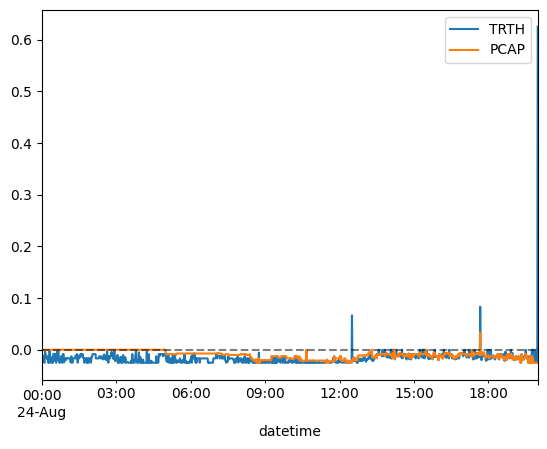

In [25]:
ax = results.plot()
ax.axhline(0, ls='--', color='black', alpha=0.5)

In [26]:
print (results[results.TRTH > 0].TRTH)

datetime
2023-08-24 00:40:00+00:00    3.952754e-16
2023-08-24 02:38:00+00:00    5.236579e-15
2023-08-24 12:30:00+00:00    6.666667e-02
2023-08-24 13:44:00+00:00    8.326673e-17
2023-08-24 14:31:00+00:00    8.500145e-16
2023-08-24 17:40:00+00:00    8.333333e-02
2023-08-24 18:06:00+00:00    3.417877e-15
2023-08-24 18:54:00+00:00    4.988178e-15
2023-08-24 19:55:00+00:00    2.707895e-15
2023-08-24 19:59:00+00:00    6.250000e-01
Name: TRTH, dtype: float64


In [27]:
print (results[results.PCAP > 0].PCAP)

datetime
2023-08-24 17:40:00+00:00    0.033333
Freq: T, Name: PCAP, dtype: float64


### Investigation

In [28]:
def remove_missing_timestamps(sym_trth, sym_pcap):
    # Remove missing timestamps when refinitiv does not have them
    # This happens when the prices is the same between minutes
    # I am unsure if it is Refinitiv and Post Processing in MFT
    missings = sym_pcap.index.difference(sym_trth.index)
    return sym_pcap.drop(missings)

def remove_timestamps_with_nans(sym_trth, sym_pcap):
    nan_index = sym_pcap[(sym_pcap.bid.isna()) | (sym_pcap.ask.isna())].index
    sym_trth_temp = sym_trth.drop(nan_index)
    sym_pcap_temp = sym_pcap.drop(nan_index)
    nan_index = sym_trth_temp[(sym_trth_temp.bid.isna()) | (sym_trth_temp.ask.isna())].index
    sym_trth_final = sym_trth_temp.drop(nan_index)
    sym_pcap_final = sym_pcap_temp.drop(nan_index)
    return sym_trth_final, sym_pcap_final

def check_option(trade_date, symbol: str, trth_df, pcap_df):
    
    sym_trth = trth_df[(trth_df.symbol == symbol)]
    sym_pcap = pcap_df[(pcap_df.symbol == symbol)]
    
    print (f'TRTH len: {len(sym_trth)}')
    print (f'PCAP len: {len(sym_pcap)}')

    # We know that we could have missing timestamps in both sides and we just want to check the
    # ones in common
    sym_pcap_filtered = remove_missing_timestamps(sym_trth, sym_pcap)
    sym_trth_filtered = remove_missing_timestamps(sym_pcap_filtered, sym_trth)


    print (f'TRTH missing len: {len(sym_trth_filtered)}')
    print (f'PCAP missing len: {len(sym_pcap_filtered)}')
    
    # We remove the nans as the logic in Refinitiv is dodgy
    sym_trth_filtered, sym_pcap_filtered = remove_timestamps_with_nans(sym_trth_filtered, sym_pcap_filtered)

    print (f'TRTH filtered len: {len(sym_trth_filtered)}')
    print (f'PCAP filtered len: {len(sym_pcap_filtered)}')

    # Log how many timestamps we have a difference
    results = pd.DataFrame()
    results['bid'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.bid) | np.isclose(sym_trth_filtered.bid, sym_pcap_filtered.bid)
    results['ask'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.ask) | np.isclose(sym_trth_filtered.ask, sym_pcap_filtered.ask)
    issues = results[~results.bid| ~results.ask]
    rich.print(issues)

check_option(calendar.get_date(20230804, forward=True), 'ES1W4445H23', trth_df, pcap_df)

TRTH len: 0
PCAP len: 0
TRTH missing len: 0
PCAP missing len: 0
TRTH filtered len: 0
PCAP filtered len: 0


Empty DataFrame
Columns: [bid, ask]
Index: []

### Getting Parquet file

In [29]:
option_strike = 4445
put_or_call = options.PutOrCall.Call
for option in option_chain:
    if int(option.strike_price) == option_strike and option.put_or_call == put_or_call:
        option_key = option.instrument_key
        break
print(option_key)

OptionSpecificInstrumentKey={option_instr_key: OptionInstrumentKey={internal_product_code: OES, date: 20230824}, expiration_date: None, strike_price: None, put_or_call: None, exchange_symbol: E4DQ3 C4445, exchange_security_id: 42131916}


In [30]:
validate_cached_downsampled_files('OES', calendar.get_date(20230804, forward=True), [option_key])

[{'symbol': 42131916,
  'date': 20230804,
  'file_location': '/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/54ce56a9/42131916/20230804.pickle',
  'ds_file_exists': False}]

In [31]:
data = get_book_data(exchange, 'OES', "42056158", calendar.get_date(20230804, forward=True), version)

/fsxcache/output/books/cme/OES/2023/08/04/v2.2/42056158


In [32]:
d = pd.DataFrame.from_dict(data['book'])
d.head()


ts  feed_sequence  last_trade_sequence  \
0  1691100206559000953      837215587                   -1   
1  1691100206559000953      837215587                   -1   
2  1691100207247504647      837217546                   -1   
3  1691100208789357753      837220271                   -1   
4  1691100210289825954      837221900                   -1   

             exch_time  latency  bookUpdateHadTrade        offer_0  \
0  1691100206558764147        0                   0              0   
1  1691100206558764147        0                   0  8475000000000   
2  1691100207244254041        0                   0  8450000000000   
3  1691100208784923723        0                   0  8425000000000   
4  1691100210285406871        0                   0  8425000000000   

           bid_0  bid_size_0  bid_count_0  offer_size_0  offer_count_0  
0  8250000000000         1.0          1.0           0.0            0.0  
1  8250000000000         1.0          1.0           1.0            1.0  
2  8250000000000         1.0          1.0           1.0            1.0  
3  8250000000000         1.0          1.0           1.0            1.0  
4  8225000000000         1.0          1.0           1.0            1.0

In [33]:
rich.print(pd.Timestamp(d.ts.min()))
rich.print(pd.Timestamp(d.ts.max()))

2023-08-03 22:03:26.559000953

2023-08-04 19:59:52.252849396

In [34]:
# Left labelled - 08:07 is last price before 08:08
start_time = pd.Timestamp(f"2023-08-04 17:32:00+00:00")
end_time = pd.Timestamp(f"2023-08-04 17:33:00+00:00")
print (start_time.timestamp(), end_time.timestamp())

1691170320.0 1691170380.0


In [35]:
d[(d.ts / 1000000000 >= start_time.timestamp()) & (d.ts /1000000000 < end_time.timestamp())]

ts  feed_sequence  last_trade_sequence  \
238709  1691170320259482703     1014650295           1012397774   
238710  1691170320445878107     1014650645           1012397774   
238711  1691170320507154729     1014650932           1012397774   
238712  1691170323558931679     1014658735           1012397774   
238713  1691170323578556000     1014659405           1012397774   
...                     ...            ...                  ...   
239141  1691170379790592401     1015016970           1012397774   
239142  1691170379802144678     1015017125           1012397774   
239143  1691170379810324499     1015017260           1012397774   
239144  1691170379903598741     1015018908           1012397774   
239145  1691170379952599642     1015020472           1012397774   

                  exch_time  latency  bookUpdateHadTrade         offer_0  \
238709  1691170320259223283        0                   0  10500000000000   
238710  1691170320445003991        0                   0  10500000000000   
238711  1691170320506891277        0                   0  10500000000000   
238712  1691170323541810633        0                   0  10500000000000   
238713  1691170323549805353        0                   0  10500000000000   
...                     ...      ...                 ...             ...   
239141  1691170379788595159        0                   0  10325000000000   
239142  1691170379788646249        0                   0  10350000000000   
239143  1691170379788646691        0                   0  10375000000000   
239144  1691170379789056253        0                   0               0   
239145  1691170379802952709        0                   0  10350000000000   

                 bid_0  bid_size_0  bid_count_0  offer_size_0  offer_count_0  
238709  10450000000000         2.0          2.0           3.0            3.0  
238710  10450000000000         1.0          1.0           3.0            3.0  
238711  10450000000000         1.0          1.0           3.0            3.0  
238712  10450000000000         1.0          1.0           2.0            2.0  
238713  10450000000000         2.0          2.0           2.0            2.0  
...                ...         ...          ...           ...            ...  
239141  10275000000000         1.0          1.0           1.0            1.0  
239142  10200000000000         2.0          2.0           1.0            1.0  
239143  10200000000000         2.0          2.0           1.0            1.0  
239144  10200000000000         2.0          2.0           0.0            0.0  
239145  10225000000000         1.0          1.0           1.0            1.0  

[437 rows x 12 columns]

### Unused code

In [ ]:
def check_option_toto(strike: int, put_or_call: options.PutOrCall, option_chain: list[symlib.Instrument]):
    option_key = None
    for option in option_chain:
        if int(option.strike_price) == option_strike and option.put_or_call == put_or_call:
            option_key = option.instrument_key
            break
        
    if not option_key:
        raise Exception(f'Cannot find option with strike:{strike} type:{put_or_call}')

In [ ]:
# output locations, dependent on how the FSX cache was mounted
fsx_base_path = "/fsxcache/output"
old_fsx_base_path = "/fsxcache/old_output"
secdef_base_path = fsx_base_path

# /{fsx_location}/secdef/cboe/2023/01/SPX.20230101.secdef.json.gz
if exchange == "cme":
    secdef_location = secdef_base_path + "/secdef/{year}/{month}/{security_group}.{year}{month}{day}.secdef.json.gz"
elif exchange == "cboe":
    secdef_location = secdef_base_path + "/secdef/cboe/{year}/{month}/{security_group}.{year}{month}{day}.secdef.json.gz"

# /{fsx_location}/stream/cboe/outright/2023/01/03/v5/34/20230103.direct.gz
if exchange == "cme":
    stream_base_location = fsx_base_path + "/stream/{exchange}/{gsym}/{type_identifier}/{year}/{month}/{day}/{version}/{channel_identifier}"
    stream_location = stream_base_location + "/{year}{month}{day}.direct.gz"
elif exchange == "cboe":
    stream_base_location = old_fsx_base_path + "/stream/{exchange}/{type_identifier}/{year}/{month}/{day}/{version}/{channel_identifier}"
    stream_location = stream_base_location + "/{year}{month}{day}.direct.gz"
    
# /{fsx_location}/books/cboe/2023/08/01/v5/03PHfG/book.parquet
if exchange == "cme":
    book_location = fsx_base_path + "/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
elif exchange == "cboe":
    book_location = old_fsx_base_path + "/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
elif exchange == "nymx":
    book_location = fsx_base_path + "/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"

type_identifier = "complex" if is_complex else "outright"
channel_by_gsym = {
    "OSPX": 33,
    "OSPXW": 34,
    "OES": 311,
    "OS0": 313,
    "OTY": 345,
    "OCL": 383,
    "ONQ": 319,
    "ORTY": 319,
    "ONG": 387,
    # "OG": 361,
    "OC": 341,
    "OS": 341,
}

In [ ]:
# setup query for the data validation

# cboe data available from 20220423-20230930
# public holidays: 20230101-2

start_date = 20230802
end_date = 20230802
gsyms = ["OES"] #, "OS0", "OTY", "OCL", "ONG", "ONQ", "ORTY", "OC", "OS"]


In [ ]:
# Results for OSPXW 2023-07-03
# SPXWs032343250.U Min Timestamp: trth:2023-07-03 00:15:00+00:00 pcap:2023-07-03 05:00:00+00:00 equal:False
# SPXWs032343250.U Max Timestamp: trth:2023-07-03 16:59:00+00:00 pcap:2023-07-03 17:00:00+00:00 equal:False

# Results: /fsxcache/old_output/books/cboe/2023/07/03/v5/03MCZH
# 2023-07-03 00:00:00.572611197
# 2023-07-03 17:00:00.065718248




# Results for OSPXW
# SPXWu292232250.U Min Timestamp: trth:2022-09-29 00:15:00+00:00 pcap:2022-09-29 13:15:00+00:00 equal:False
# SPXWu292232250.U Max Timestamp: trth:2022-09-29 19:59:00+00:00 pcap:2022-09-29 19:07:00+00:00 equal:False
# 2022-09-29 13:15:00.889968372
# 2022-09-29 19:07:21.873775981
